In [0]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')

In [121]:
#req1 = req1[20000:2005000]
#gen_req1 = gen_req1[20000:2005000]
req1.shape,gen_req1.shape

((2005000,), (2255000,))

In [0]:
N = 100 # total ids 
pi = 3.14
C = 5 #cache memory

LRU

In [0]:
def LRU(y, x, request_time,con):
  [N,I] = x.shape
  J = len(y)

  for j in range(J):
    x_t_j = np.zeros(N)
    file_req_time = np.zeros(N)

    # to find which users are connected to this cache 
    connected_users = []
    for k in range(I):
      if con[k,j] == 1:
        connected_users.append(k)
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_req_time = np.maximum(file_req_time, request_time[:,connected_users[k]])
    x_t_j = np.minimum(np.ones(N),x_t_j)

    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))# file which is not requested but still in the cache
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) # file requested but not in the cache.
    a = np.sum(a1)
    b = np.sum(b1)

    if a>0 and b>0:
      if a>b:
        ind = []
        for k in range(N):
          if a1[k] == 1:
            ind.append(k)
        t = np.zeros(a)
        for k in range(a):
          t[k] = file_req_time[ind[k]]
        replace = (t).argsort()[:b]
        for k in range(b):
          y[j,ind[int(replace[k])]] = 0
        for k in range(N):
          if b1[k] == 1:
            y[j,k] = 1
      
      else:
        for k in range(N):
          if a1[k] == 1:
            y[j,k] = 0
        
        ind = []
        for k in range(N):
          if b1[k] == 1:
            ind.append(k)
        t = np.zeros(b)
        for k in range(b):
          t[k] = file_req_time[ind[k]]
        replace = (t).argsort()[:a]
        for k in range(a):
          y[j,ind[int(replace[k])]] = 1

  return y

LFU

In [0]:
def LFU(y,x,freq,con):
  [N,I] = x.shape
  J = len(y)

  for j in range(J):
    file_freq = np.zeros(N)
    x_t_j = np.zeros(N)

    # to find which users are connected to this cache 
    connected_users = []
    for k in range(I):
      if con[k,j] == 1:
        connected_users.append(k)
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_freq += freq[:,connected_users[k]]
    x_t_j = np.minimum(np.ones(N),x_t_j)

    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))# file which is not requested but still in the cache
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) # file requested but not in the cache.
    a = np.sum(a1)
    b = np.sum(b1)
  
    if a>0 and b>0:
      if a>b:
        ind = []
        for k in range(N):
          if a1[k] == 1:
            ind.append(k)
        t = np.zeros(a)
        for k in range(a):
          t[k] = file_freq[ind[k]]
        replace = (t).argsort()[:b]
        for k in range(b):
          y[j,ind[int(replace[k])]] = 0
        for k in range(N):
          if b1[k] == 1:
            y[j,k] = 1
      else:
        for k in range(N):
          if a1[k] == 1:
            y[j,k] = 0
        ind = []
        for k in range(N):
          if b1[k] == 1:
            ind.append(k)
        t = np.zeros(b)
        for k in range(b):
          t[k] = file_freq[ind[k]]
        replace = (t).argsort()[:a]
        for k in range(a):
          y[j,ind[int(replace[k])]] = 1

  return y

perturbed count

In [0]:
def per_count(eta,count):
  [N,I] = count.shape
  p_count = np.zeros((N,I),dtype = float)
  for i in range(I):
    p_count[:,i] = count[:,i] + np.multiply(eta, random.normal(0,1,[N,1])).reshape(N)
  return p_count

SINGLE CACHE

In [122]:
I = 1 #users
T = 50000
degree = 1
J = 1 #caches
connection = np.array([[1]])
connection.shape

(1, 1)

In [123]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(1, 50000)

In [124]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(1, 50000)

In [125]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)

reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []

req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)
  
  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = I*pow(4*pi*np.log(N*I),-.25)*pow(T/(J*degree*C),.5)
  perturbed_count=per_count(eta,count)
  y_FTPL = np.zeros((J,N),dtype = float)
  y_opt = np.zeros((J,N),dtype = float)
  
  
  eta = pow(4*pi*np.log(N),-.25)*pow(T/C,.5)
  perturbed_count=per_count(eta,count)

  add = (-perturbed_count[:,0]).argsort()[:C]
  y_FTPL = np.zeros((J,N),dtype = float)

  for k in range(len(add)):
    y_FTPL[0,int(add[k])] = 1 

  
  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %1000 == 0:
    print(t,hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 0.0 0.0 0.0 0.0
1000 53.0 45.0 55.0 55.0
2000 101.0 100.0 107.0 107.0
3000 161.0 158.0 161.0 161.0
4000 219.0 223.0 212.0 212.0
5000 276.0 284.0 265.0 265.0
6000 328.0 355.0 315.0 315.0
7000 379.0 424.0 359.0 359.0
8000 431.0 490.0 408.0 408.0
9000 499.0 554.0 467.0 467.0
10000 540.0 604.0 524.0 524.0
11000 600.0 667.0 561.0 561.0
12000 672.0 732.0 604.0 604.0
13000 726.0 810.0 659.0 659.0
14000 797.0 899.0 723.0 723.0
15000 861.0 964.0 777.0 777.0
16000 914.0 1028.0 817.0 817.0
17000 969.0 1084.0 864.0 864.0
18000 1025.0 1154.0 910.0 910.0
19000 1101.0 1219.0 960.0 960.0
20000 1147.0 1286.0 1007.0 1007.0
21000 1207.0 1349.0 1052.0 1132.0
22000 1282.0 1432.0 1110.0 1262.0
23000 1335.0 1481.0 1169.0 1397.0
24000 1400.0 1551.0 1219.0 1547.0
25000 1464.0 1624.0 1272.0 1696.0
26000 1526.0 1700.0 1330.0 1831.0
27000 1595.0 1773.0 1388.0 1966.0
28000 1656.0 1828.0 1433.0 2095.0
29000 1724.0 1894.0 1477.0 2256.0
30000 1797.0 1972.0 1536.0 2385.0
31000 1874.0 2057.0 1593.0 2508.0
32000 1928.

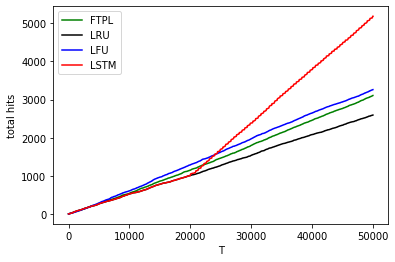

In [126]:
plt.plot(hits_FTPL,'green',label='FTPL')
plt.plot(hits_LRU,'black',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()

BIPARTITE NETWORK

In [0]:
I = 15
J = 10
degree = 7
T = 2500

In [64]:
connection = np.zeros((I,J),dtype = int)
j = 0
for i in range(I):
    x = 0
    while x < degree:
        connection[i,j] = 1
        x += 1
        j += 1
        if j == J:
          j = 0
connection

array([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
       [1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
       [1, 1, 1, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
       [1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 1, 1]])

In [0]:
req1 = req1[20000:2005000]
gen_req1 = gen_req1[20000:2005000]

In [66]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(15, 2500)

In [67]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(15, 2500)

In [68]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)
regret_LRU =  np.zeros(T)
regret_LFU =  np.zeros(T)
regret_FTPL =  np.zeros(T)
regret_LSTM = np.zeros(T)
reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
hits_optimal = []


req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)
  
  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = I*pow(4*pi*np.log(N*I),-.25)*pow(T/(J*degree*C),.5)
  perturbed_count=per_count(eta,count)
  y_FTPL = np.zeros((J,N),dtype = float)
  y_opt = np.zeros((J,N),dtype = float)

  for j in range(J):
    max_opt = np.zeros(N)
    for f in range(N):
      y_opt[j,f] = 1
      z_opt = np.zeros((I,N), dtype = float)
      for i in range(I):
        for k in range(J):
          if connection[i,k] == 1:
            z_opt[i] += y_opt[k]
        z_opt[i] = np.minimum(np.ones(N),z_opt[i].reshape(N))
        max_opt[f] += np.dot(z_opt[i],count[:,i]) 
      y_opt[j,f] = 0
    f_opt = (-max_opt).argsort()[:C]
    for k in range (C):
      y_opt[j,f_opt[k]] = 1

  if t%3 == 0:
    for j in range(J):
      max_FTPL = np.zeros(N)
      for f in range(N):
        y_FTPL[j,f] = 1
        z_FTPL = np.zeros((I,N), dtype = float)
        for i in range(I):
          for k in range(J):
            if connection[i,k] == 1:
              z_FTPL[i] += y_FTPL[k]
          z_FTPL[i] = np.minimum(np.ones(N),z_FTPL[i].reshape(N))
        max_FTPL[f] += np.dot(z_FTPL[i],perturbed_count[:,i])  
        y_FTPL[j,f] = 0
      f_FTPL = (-max_FTPL).argsort()[:C]
      for k in range (C):
        y_FTPL[j,f_FTPL[k]] = 1
    
  #OPTIMAL
  reward_optimal =  np.zeros(T)
  for t1 in range(t+1):
    x = np.zeros((N,I),dtype = int)
    for i in range(I):
      x[int(req[i,t1]),i] += 1
      
    ireward_optimal =  np.zeros(I)
    for i in range(I):
      connected_cache = []
      for j in range(J):
        if connection[i,j] == 1:
          connected_cache.append(j)
      otemp = np.zeros(N)  
      for k in range(len(connected_cache)):
        otemp += y_opt[connected_cache[k],:]  
      ireward_optimal[i] += np.dot(np.minimum(np.ones(N),otemp),x[:,i])
    
    reward_optimal[t1] = np.sum(ireward_optimal)
  reward_optimalc = np.sum(reward_optimal)


  hits_optimal.append(reward_optimalc)  
  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)
  regret_FTPL[t] = (reward_optimalc - reward_FTPLc)/(t+1)
  regret_LFU[t] = (reward_optimalc - reward_LFUc)/(t+1)
  regret_LRU[t] = (reward_optimalc - reward_LRUc)/(t+1)
  regret_LSTM[t] = (reward_optimalc - reward_LSTMc)/(t+1)
  if t %100 == 0:
    print(t,regret_FTPL[t],regret_LFU[t],regret_LRU[t],regret_LSTM[t],reward_optimalc)

0 15.0 15.0 15.0 14.0 15.0
100 6.673267326732673 6.524752475247524 6.702970297029703 6.445544554455446 815.0
200 5.920398009950249 5.845771144278607 5.985074626865671 5.731343283582089 1475.0
300 5.53156146179402 5.465116279069767 5.59468438538206 5.392026578073089 2090.0
400 5.3366583541147135 5.3192019950124685 5.44139650872818 5.179551122194514 2698.0
500 5.189620758483034 5.173652694610778 5.3053892215568865 4.8822355289421155 3285.0
600 5.071547420965058 5.02495840266223 5.168053244592346 4.788685524126456 3882.0
700 4.974322396576319 4.977175463623396 5.1055634807417976 4.748930099857347 4487.0
800 4.955056179775281 4.987515605493134 5.091136079900124 4.747815230961298 5107.0
900 4.914539400665927 4.945615982241954 5.039955604883462 4.617092119866815 5699.0
1000 4.903096903096903 4.934065934065934 5.018981018981019 4.654345654345654 6320.0
1100 4.83197093551317 4.8628519527702085 4.932788374205268 4.5858310626703 6872.0
1200 4.796003330557869 4.856786011656952 4.912572855953372 4

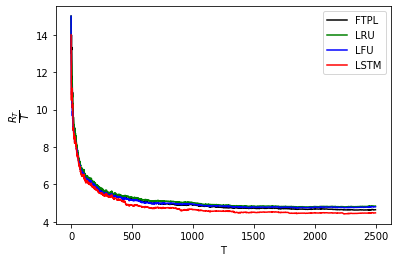

In [69]:
plt.plot(regret_FTPL,'black',label='FTPL')
plt.plot(regret_LRU,'green',label='LRU')
plt.plot(regret_LFU,'blue',label='LFU')
plt.plot(regret_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('$ \dfrac{R_T}{T}$')
plt.legend()

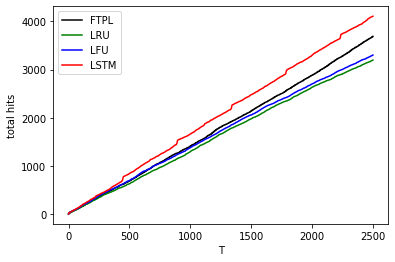

In [70]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()



I = 5 and J = 3

In [0]:
I = 5
J = 3
degree = 2
T = 2500

In [0]:
connection = np.zeros((I,J),dtype = int)
j = 0
for i in range(I):
    x = 0
    while x < degree:
        connection[i,j] = 1
        x += 1
        j += 1
        if j == J:
          j = 0

In [73]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(5, 2500)

In [74]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(5, 2500)

In [75]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)
regret_LRU =  np.zeros(T)
regret_LFU =  np.zeros(T)
regret_FTPL =  np.zeros(T)
regret_LSTM = np.zeros(T)
reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
hits_optimal = []


req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)
  
  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = I*pow(4*pi*np.log(N*I),-.25)*pow(T/(J*degree*C),.5)
  perturbed_count=per_count(eta,count)
  y_FTPL = np.zeros((J,N),dtype = float)
  y_opt = np.zeros((J,N),dtype = float)

  for j in range(J):
    max_opt = np.zeros(N)
    for f in range(N):
      y_opt[j,f] = 1
      z_opt = np.zeros((I,N), dtype = float)
      for i in range(I):
        for k in range(J):
          if connection[i,k] == 1:
            z_opt[i] += y_opt[k]
        z_opt[i] = np.minimum(np.ones(N),z_opt[i].reshape(N))
        max_opt[f] += np.dot(z_opt[i],count[:,i]) 
      y_opt[j,f] = 0
    f_opt = (-max_opt).argsort()[:C]
    for k in range (C):
      y_opt[j,f_opt[k]] = 1

  for j in range(J):
    max_FTPL = np.zeros(N)
    for f in range(N):
      y_FTPL[j,f] = 1
      z_FTPL = np.zeros((I,N), dtype = float)
      for i in range(I):
        for k in range(J):
          if connection[i,k] == 1:
            z_FTPL[i] += y_FTPL[k]
        z_FTPL[i] = np.minimum(np.ones(N),z_FTPL[i].reshape(N))
      max_FTPL[f] += np.dot(z_FTPL[i],perturbed_count[:,i])  
      y_FTPL[j,f] = 0
    f_FTPL = (-max_FTPL).argsort()[:C]
    for k in range (C):
      y_FTPL[j,f_FTPL[k]] = 1
    
  #OPTIMAL
  reward_optimal =  np.zeros(T)
  for t1 in range(t+1):
    x = np.zeros((N,I),dtype = int)
    for i in range(I):
      x[int(req[i,t1]),i] += 1
      
    ireward_optimal =  np.zeros(I)
    for i in range(I):
      connected_cache = []
      for j in range(J):
        if connection[i,j] == 1:
          connected_cache.append(j)
      otemp = np.zeros(N)  
      for k in range(len(connected_cache)):
        otemp += y_opt[connected_cache[k],:]  
      ireward_optimal[i] += np.dot(np.minimum(np.ones(N),otemp),x[:,i])
    
    reward_optimal[t1] = np.sum(ireward_optimal)
  reward_optimalc = np.sum(reward_optimal)


  hits_optimal.append(reward_optimalc)  
  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)
  regret_FTPL[t] = (reward_optimalc - reward_FTPLc)/(t+1)
  regret_LFU[t] = (reward_optimalc - reward_LFUc)/(t+1)
  regret_LRU[t] = (reward_optimalc - reward_LRUc)/(t+1)
  regret_LSTM[t] = (reward_optimalc - reward_LSTMc)/(t+1)
  if t %100 == 0:
    print(t,regret_FTPL[t],regret_LFU[t],regret_LRU[t],regret_LSTM[t],reward_optimalc)

0 5.0 5.0 5.0 5.0 5.0
100 0.6336633663366337 0.7722772277227723 0.7722772277227723 0.5742574257425742 124.0
200 0.5174129353233831 0.5472636815920398 0.5920398009950248 0.417910447761194 206.0
300 0.4219269102990033 0.4584717607973422 0.5182724252491694 0.3521594684385382 276.0
400 0.38902743142144636 0.4538653366583541 0.48129675810473815 0.34663341645885287 349.0
500 0.34331337325349304 0.4091816367265469 0.4471057884231537 0.2275449101796407 421.0
600 0.3277870216306156 0.3810316139767055 0.40931780366056575 0.22628951747088186 490.0
700 0.2967189728958631 0.340941512125535 0.37375178316690444 0.1840228245363766 547.0
800 0.2746566791510612 0.3196004993757803 0.35830212234706615 0.18102372034956304 610.0
900 0.2619311875693674 0.3118756936736959 0.3340732519422864 0.10321864594894561 666.0
1000 0.24875124875124874 0.2937062937062937 0.3176823176823177 0.11488511488511488 731.0
1100 0.23251589464123523 0.28792007266121705 0.3079019073569482 0.11171662125340599 795.0
1200 0.2339716902

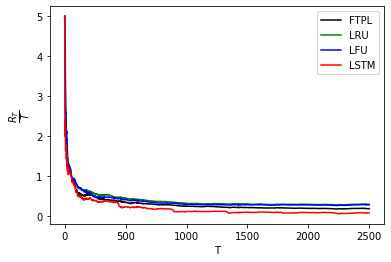

In [76]:
plt.plot(regret_FTPL,'black',label='FTPL')
plt.plot(regret_LRU,'green',label='LRU')
plt.plot(regret_LFU,'blue',label='LFU')
plt.plot(regret_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('$ \dfrac{R_T}{T}$')
plt.legend()

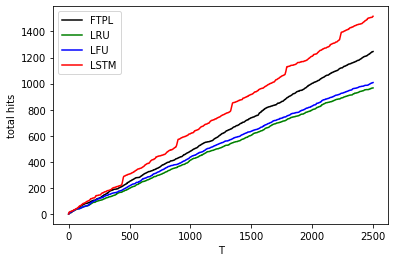

In [77]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()